In [ ]:
%%html
<script>
(function() {
  // Create the toggle button
  const rtlButton = document.createElement("button");
  rtlButton.textContent = "Toggle LTR";
  rtlButton.id = "top-rtl-toggle";
  rtlButton.style.marginLeft = "8px";
  rtlButton.style.padding = "4px 10px";
  rtlButton.style.fontSize = "14px";
  rtlButton.style.cursor = "pointer";

  // State
  var rtlActive = false;

  // Styling function
  var applyStyleToEditor = (editor) => {
    if (!editor) return;
    var direction = getComputedStyle(editor).getPropertyValue('direction')=='rtl' ? 'ltr' : 'rtl';
    var text_align = getComputedStyle(editor).getPropertyValue('text-align')=='right' ? 'left' : 'right';
    editor.style.setProperty('direction', direction, 'important');
    editor.style.setProperty('text-align', text_align, 'important');
  };

  // Toggle logic
  rtlButton.onclick = () => {
    rtlActive = !rtlActive;
    rtlButton.textContent = rtlActive ? "Toggle LTR" : "Toggle RTL";
    document.querySelectorAll('.jp-MarkdownCell .jp-InputArea-editor').forEach(applyStyleToEditor);
    document.querySelectorAll('.jp-RenderedHTMLCommon code, .jp-RenderedHTMLCommon code span').forEach(applyStyleToEditor);
    document.querySelectorAll('jp-RenderedHTMLCommon, .jp-RenderedHTMLCommon *').forEach(applyStyleToEditor);
  };

  // Watch for focus into editing Markdown cells
  // document.addEventListener('focusin', (event) => {
  //   const editor = event.target.closest('.jp-MarkdownCell .jp-InputArea-editor');
  //    if (editor) applyStyleToEditor(editor);
  // });

  // Insert into top toolbar if not already present
  var insertIntoToolbar = () => {
    const toolbar = document.querySelector('.jp-NotebookPanel-toolbar');
    if (toolbar && !document.getElementById("top-rtl-toggle")) {
      toolbar.appendChild(rtlButton);
    } else {
      // Try again in a moment if toolbar isn't ready yet
      setTimeout(insertIntoToolbar, 300);
    }
  };

  insertIntoToolbar();
})();
</script>

In [ ]:
%%html
<!-- <style>
  table {display: inline-block}
</style> -->

## דוגמה מסכמת (1): פירוק SVD על תמונה (או על תמונה סינתטית)

בואו נראה איך אפשר להשתמש ב־SVD לדחיסת תמונה.  
דחיסה היא תהליך שבו אנחנו מצמצמים את כמות המידע הדרושה לייצוג של אובייקט (כמו תמונה, וידאו או קובץ טקסט), מבלי לאבד יותר מדי מהתוכן המקורי. הרעיון הוא להשתמש בפחות ביטים כדי לאחסן או לשדר את אותו המידע.
הרעיון: במקום לשמור את כל הפיקסלים של התמונה, נפרק את מטריצת התמונה ל־$U \Sigma V^T$,  
ונשמור רק את כמה הערכים הסינגולריים הגדולים ביותר.  

כך מקבלים קירוב טוב מאוד לתמונה המקורית, אבל עם הרבה פחות מידע.

### דחיסת תמונה סינתטית

נחשוב על תמונה כעל טבלה של מספרים בין 0 ל־1 (שחור–לבן).  
נבנה תמונה פשוטה: עיגול בהיר על רקע בהיר־קצת (גרדיאנט).  
נבצע פירוק $A = U \Sigma V^T$ ונשחזר את התמונה עם $k$ הערכים הסינגולריים הגדולים בלבד.

רעיון מרכזי:
- $\sigma_1, \sigma_2, \ldots$ (הערכים הסינגולריים) מסודרים מהגדול לקטן.
- שמירה רק על $k$ הגדולים נותנת קירוב טוב של התמונה, אבל עם פחות מידע (דחיסה).


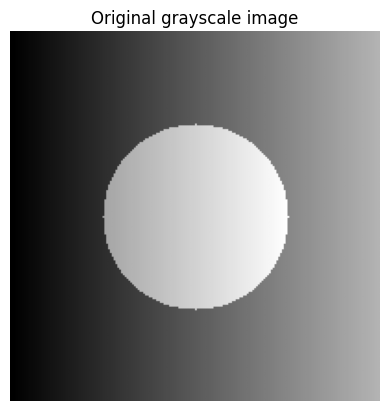

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Build a simple 2D grayscale "image" (no external libraries)
H, W = 200, 200
y, x = np.ogrid[:H, :W]

# Simple circle mask
radius = H // 4
circle = ((x - W//2)**2 + (y - H//2)**2) <= radius**2
circle = circle.astype(float)

# Horizontal gradient in [0,1]
grad = x / (W - 1)

# Mix: image = 0.6*gradient + 0.4*circle
img = 0.6 * grad + 0.4 * circle

# Show the original grayscale image
plt.figure()
plt.title("Original grayscale image")
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()


נבצע את ה־SVD של המטריצה (התמונה) ונראה את הממדים שהתקבלו ואת מספר הערכים הסינגולריים הראשונים.

In [17]:
# Compute SVD
U, s, Vt = np.linalg.svd(img, full_matrices=False)

print("Shapes:")
print("U:", U.shape, " s:", s.shape, " Vt:", Vt.shape)

# Print first few singular values (they are already 1D numbers)
print("First 5 singular values:", s[:5])


Shapes:
U: (200, 200)  s: (200,)  Vt: (200, 200)
First 5 singular values: [87.14902758 15.56242399  7.92470633  4.5784639   3.2616076 ]


פונקציית השחזור מבוססת על פירוק ה־SVD:

$$
A = U \cdot \Sigma \cdot V^T
$$

כאשר:
* $U$ – מטריצה שכל העמודות שלה אורתונורמליות (כל אחת היא כיוון בסיסי "חדש").
* $V^T$ – מטריצה אורתונורמלית אחרת שמייצגת כיוונים בצד השני.
* $\Sigma$ – מטריצה אלכסונית (רוב הערכים בה אפס), ועל האלכסון נמצאים הערכים הסינגולריים 
  $\sigma_1 \geq \sigma_2 \geq \dots \geq 0$.


#### קירוב בעזרת $k$ רכיבים בלבד
בפועל, רוב התרומה של המטריצה $A$ מגיעה מהערכים הסינגולריים הגדולים ביותר.  
לכן אפשר לכתוב קירוב:

$$
A_k = U_{(:,1:k)} \cdot \mathrm{diag}(\sigma_1,\dots,\sigma_k) \cdot V^T_{(1:k,:)}
$$

```{note}
נסביר:
* $U_{(:,1:k)}$ – לוקחים רק את $k$ העמודות הראשונות של $U$.
* $\mathrm{diag}(\sigma_1,\dots,\sigma_k)$ – שומרים רק את $k$ הערכים הסינגולריים הגדולים ביותר.
* $V^T_{(1:k,:)}$ – לוקחים את $k$ השורות הראשונות של $V^T$.
```

`````{admonition} אינטואיציה
:class: tip
אפשר לחשוב על זה כמו לבנות את המטריצה $A$ כ"סכום של שכבות" (layers):

$$
A = \sigma_1 u_1 v_1^T + \sigma_2 u_2 v_2^T + \cdots
$$

כאשר $u_i$ הוא העמודה ה־$i$ של $U$ ו־$v_i^T$ היא השורה ה־$i$ של $V^T$.

אם לוקחים רק את $k$ הראשונים:

$$
A_k = \sigma_1 u_1 v_1^T + \cdots + \sigma_k u_k v_k^T,
$$

אנחנו מקבלים קירוב פשוט יותר – פחות "שכבות" – אבל קרוב מאוד ל־$A$ אם הערכים שנזרקו היו קטנים.

:בהקשר של תמונה
* כאשר $k$ קטן (למשל $k=5$) – רואים את הצורה הכללית של התמונה אבל בלי פרטים.
* כאשר $k$ בינוני (למשל $k=20$) – התמונה כבר נראית די טובה.
* כאשר $k$ גדול (למשל $k=60$) – התמונה כמעט זהה למקור.
`````

כך ניתן לדחוס את המידע: לשמור הרבה פחות נתונים (רק $k$ ערכים וכמה וקטורים) ועדיין לשחזר תמונה קרובה מאוד למקור.


In [ ]:
def svd_approx(U, s, Vt, k):
    # Reconstruct using the top-k singular values/vectors
    k = int(max(1, min(k, s.size)))  # clamp k to [1, rank]
    return (U[:, :k] * s[:k]) @ Vt[:k, :]

for k in [5, 20, 60]:
    approx = svd_approx(U, s, Vt, k)

    # Relative reconstruction error ||A - A_k|| / ||A||
    rel_err = np.linalg.norm(img - approx) / np.linalg.norm(img)
    print(f"k={k:>3}  relative error ≈ {rel_err:.4f}")

    plt.figure()
    plt.title(f"SVD approximation with k={k}")
    plt.imshow(approx, cmap="gray")
    plt.axis("off")
    plt.show()


### כמה אנרגיה נשמרה?

כדי למדוד עד כמה הקירוב $A_k$ שומר על המידע של המטריצה המקורית $A$, משתמשים ב**אנרגיה**.

ב־SVD, הערכים הסינגולריים $\sigma_i$ מודדים כמה חזקה התרומה של כל רכיב $i$ לתמונה או לנתונים.  
ככל שהערך $\sigma_i$ גדול יותר – הוא מייצג יותר מידע חשוב.

### מדד האנרגיה
נגדיר את סך כל האנרגיה של המטריצה כ־

$$
E_\text{total} = \sum_{i=1}^r \sigma_i^2
$$

כאשר $r = \min(m,n)$ הוא הדרגה המקסימלית האפשרית.

אם אנחנו שומרים רק את $k$ הערכים הסינגולריים הגדולים ביותר, אז האנרגיה שנשמרה היא:

$$
E(k) = \sum_{i=1}^k \sigma_i^2
$$

ולכן היחס (כלומר כמה אחוז מהמידע נשמר) הוא:

$$
\text{Ratio}(k) = \frac{E(k)}{E_\text{total}} = \frac{\sum_{i=1}^k \sigma_i^2}{\sum_{i=1}^r \sigma_i^2}
$$

`````{admonition} אינטואיציה
:class: tip
* אם $k$ קטן – נשמר רק אחוז קטן מהאנרגיה, כלומר התמונה משוחזרת חלקית בלבד.
* אם $k$ גדול – רוב האנרגיה נשמרת, והתמונה כמעט זהה למקור.
* לכן נוהגים לבחור $k$ כך שנשמר נניח **90%–95% מהאנרגיה**, מה שנותן איזון טוב בין איכות הקירוב לבין גודל הנתונים.
`````

במילים פשוטות: היחס $\text{Ratio}(k)$ אומר לנו כמה מה"תוכן החשוב" של המטריצה המקורית הצלחנו לשמור בקירוב שלנו.


k=  5  energy ≈  99.6%
k= 20  energy ≈ 100.0%
k= 60  energy ≈ 100.0%
k=100  energy ≈ 100.0%


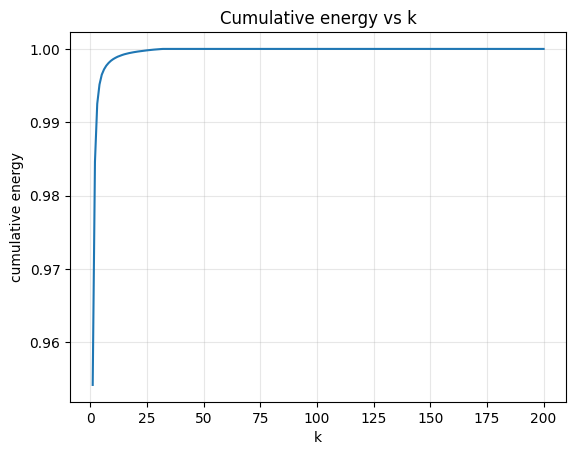

In [19]:
energy_cum = np.cumsum(s**2) / np.sum(s**2)
for k in [5, 20, 60, 100]:
    if k <= s.size:
        print(f"k={k:>3}  energy ≈ {energy_cum[k-1]*100:5.1f}%")

plt.figure()
plt.title("Cumulative energy vs k")
plt.plot(np.arange(1, s.size+1), energy_cum)
plt.xlabel("k")
plt.ylabel("cumulative energy")
plt.grid(True, alpha=0.3)
plt.show()


### סיכום: מדידת האנרגיה המצטברת

בתא הקוד אנחנו מחשבים את **האנרגיה המצטברת** שנשמרת ככל שמוסיפים יותר ערכים סינגולריים בקירוב:

1. `np.cumsum(s**2)` – מחשב את הסכום המצטבר של $\sigma_i^2$, כלומר כמה אנרגיה מצטברת עד ערך סינגולרי מסוים $k$.
2. מחלקים ב־`np.sum(s**2)` – כדי לקבל יחס בין 0 ל־1 (או בין 0% ל־100%).
3. עבור $k=5,20,60,100$ – מדפיסים כמה אחוז מהאנרגיה נשמר.
4. מציירים גרף שבו הציר האופקי הוא $k$ (כמה ערכים סינגולריים השתמשנו), והציר האנכי הוא האנרגיה המצטברת שנשמרה.

התוצאה: רואים שהאנרגיה עולה מהר מאוד בתחילת הגרף – כלומר רק מעט ערכים סינגולריים גדולים כבר מסבירים חלק גדול מהתמונה.  
זו הסיבה ש־SVD שימושי לדחיסה: אפשר לשמור אחוז קטן מהמידע ועדיין לשחזר כמעט את כל התוכן.


In [5]:
import json
from jupyterquiz import display_quiz

example = \
'''
[{
  "question": "נניח שיש לנו תמונה בגודל 200x200 ואחרי פירוק SVD קיבלנו 200 ערכים סינגולריים. אנחנו משחזרים את התמונה עם k=20 בלבד.<br><br>מה נכון לגבי הקירוב?",
  "type": "many_choice",
  "answers": [
    {
      "answer": "התמונה תשחזר את המבנה הכללי (צורה, בהירות כללית) אבל תאבד פרטים עדינים",
      "correct": true,
      "feedback": "נכון! הערכים הראשונים מכילים את רוב המידע הגס, אך לא את כל הפרטים"
    },
    {
      "answer": "כמות המידע שנשמרת קטנה בהרבה מאשר במטריצה המקורית",
      "correct": true,
      "feedback": "נכון! במקום לשמור 200x200 פיקסלים, שומרים רק את 20 הערכים הגדולים ועוד את הווקטורים המתאימים"
    },
    {
      "answer": "התמונה המשוחזרת תהיה זהה לתמונה המקורית",
      "correct": false,
      "feedback": "לא נכון — אם לא שומרים את כל 200 הערכים הסינגולריים יש תמיד אובדן מידע"
    },
    {
      "answer": "היחס בין האנרגיה שנשמרה לבין המקור תלוי ביחס בין סכום (σ_i בריבוע) עבור i=1..20 לבין סכום (σ_i בריבוע) לכל ה־200",
      "correct": true,
      "feedback": "נכון! האנרגיה שנשמרת נקבעת על פי הערכים הסינגולריים ששמרנו"
    }
  ]
}]
'''
myquiz = json.loads(example)
display_quiz(myquiz)


<IPython.core.display.Javascript object>